In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import pandasql as ps
import calendar

In [3]:
# Import data
sales=pd.read_csv('/Users/apple/Desktop/python side project/Namesake/modified data/sales_data.csv')
items=pd.read_csv('/Users/apple/Desktop/python side project/Namesake/modified data/items_bought.csv')

# Rename column name
sales.rename(columns={'customer_id_random':'customer_id','order_id_random':'order_id','net_sales_scaled':'net_sales'},inplace=True)
items.rename(columns={'customer_id_random':'customer_id','net_sales_scaled':'net_sales'},inplace=True)

# 探索性資料分析

In [4]:
# Show sales data
sales.head()

,datetime,customer_id,order_id,net_sales
0,2023-07-22,4794497084,4472634531,8.79
1,2023-07-23,2163752822,6055468369,13.39
2,2023-08-05,2163752822,7486174375,14.50
3,2023-08-14,8872646774,6199640363,9.96
4,2023-08-06,605622184,1616493641,11.50


In [5]:
# Show items data
items.head()

,customer_id,product_type,net_sales
0,808706493,23,3.62
1,2762797853,22,3.75
2,2762797853,12,3.40
3,2762797853,16,1.78
4,2762797853,11,5.22


### 商品款式銷售分析

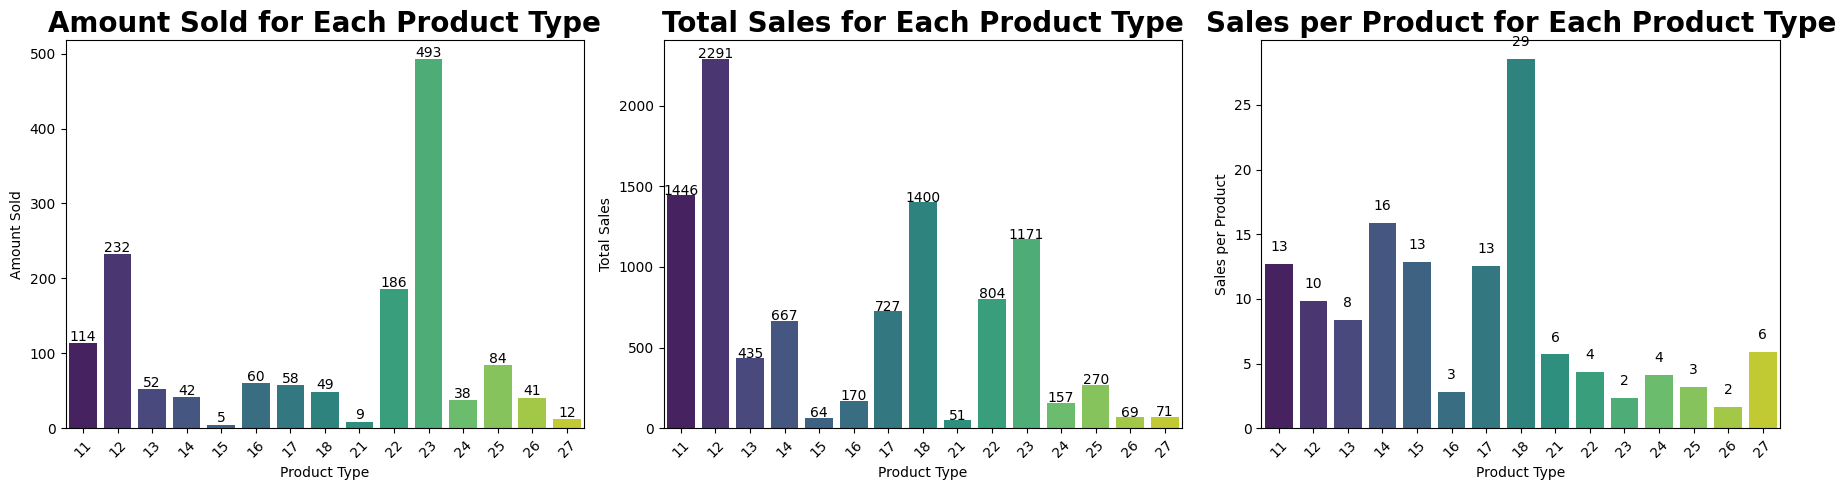

In [6]:
# Sales analysis for each product_type
# Create a new dataframe that contains the amount sold and total sales of each product type
query=''' 
SELECT
    product_type,
    COUNT(*) AS amount_sold,
    SUM(net_sales) AS total_sales
FROM
    items
GROUP BY
    product_type
'''
product_type_sales=ps.sqldf(query,locals())

# Barplot for each product type's amount sold, total sales, sales per product
plt.figure(figsize=(18, 5))

# Plot 1: Amount Sold for Each Product Type
plt.subplot(131)
s1=sns.barplot(x='product_type', y='amount_sold', data=product_type_sales, palette='viridis')
for p in s1.patches:
    s1.text(
        p.get_x()+p.get_width()/2,p.get_height()+3,f'{p.get_height():.0f}',ha='center'
    )
plt.title('Amount Sold for Each Product Type', fontsize=20, weight='bold')
plt.xlabel('Product Type')
plt.ylabel('Amount Sold')
plt.xticks(rotation=45)

# Plot 2: Total Sales for Each Product Type
plt.subplot(132)
s2=sns.barplot(x='product_type', y='total_sales', data=product_type_sales, palette='viridis')
for p in s2.patches:
    s2.text(
        p.get_x()+p.get_width()/2,p.get_height()+3,f'{p.get_height():.0f}',ha='center'
    )
plt.title('Total Sales for Each Product Type', fontsize=20, weight='bold')
plt.xlabel('Product Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# Plot 3: Sales per Product for Each Product Type
product_type_sales['sales_per_product'] = product_type_sales['total_sales'] / product_type_sales['amount_sold']

plt.subplot(133)
s3=sns.barplot(x='product_type', y='sales_per_product', data=product_type_sales, palette='viridis')
for p in s3.patches:
    s3.text(
        p.get_x()+p.get_width()/2,p.get_height()+1,f'{p.get_height():.0f}',ha='center'
    )
plt.title('Sales per Product for Each Product Type', fontsize=20, weight='bold')
plt.xlabel('Product Type')
plt.ylabel('Sales per Product')
plt.xticks(rotation=45)

# Show all plots
plt.tight_layout()

>圖表呈現三張商品銷售分析的條狀圖 
>1. 商品銷售數量（Amount Sold for Each Product Type）: 顯示每種產品類別的銷售數量。產品類型 23 的銷售數量最高（493 件），其次是產品類型 12（232 件）。  
>2. 商品銷售總額（Total Sales for Each Product Type）: 顯示每種產品類別的總收入。產品類型 12 的總收入最高（2,291），其次是 11（1,446）和 18（1,400）。  
>3. 單件商品平均銷售額（Sales per Product）: 表示每件商品的平均收入。產品類型 18 的單位銷售額最高（29），其次是 14（16）。

### 每月銷售分析

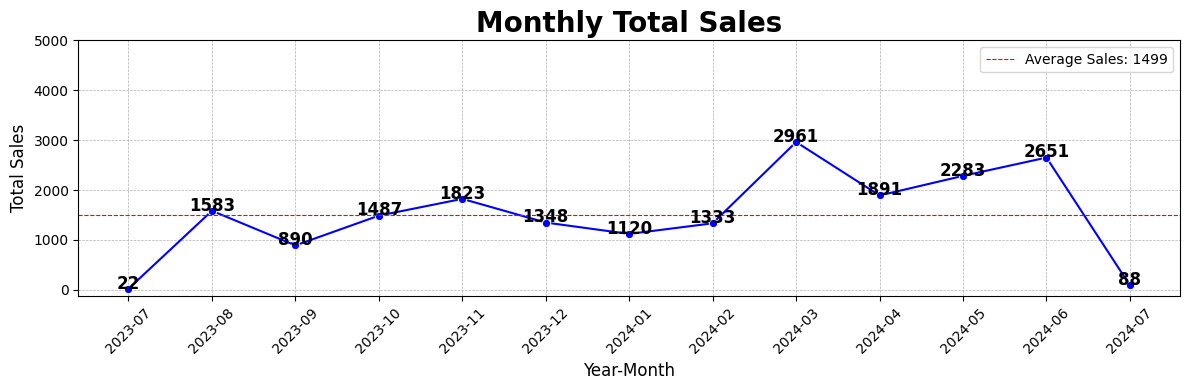

In [7]:
# Monthly Net Sales Analysis
sales['datetime']=pd.to_datetime(sales['datetime'])
query = """
    SELECT 
        strftime('%Y-%m', datetime) AS year_month,  -- Extract year and month (YYYY-MM)
        SUM(net_sales) AS total_sales
    FROM 
        sales
    GROUP BY 
        year_month
    ORDER BY 
        year_month
"""

# Execute the SQL query using pandasql
monthly_sales = ps.sqldf(query, locals())

# Convert `year_month` to string for plotting
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

# Plot lineplot
plt.figure(figsize=(12, 4))  
sns.lineplot(x='year_month', y='total_sales', data=monthly_sales, marker='o', color='b')
for x, y in zip(monthly_sales['year_month'], monthly_sales['total_sales']):
    plt.text(x, y + 3, f'{int(y)}', ha='center', fontsize=12, color='black', weight='bold')
plt.title('Monthly Total Sales', fontsize=20, weight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(0, 5200, 1000))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.axhline(monthly_sales['total_sales'].mean(), color='red', linestyle='--', linewidth=0.8, label=f'Average Sales: {monthly_sales['total_sales'].mean():.0f}')
plt.legend()

>該圖顯示了 2023 年 7 月至 2024 年 7 月 的每月總銷售量。2024 年 3 月（2,961 件） 和 2024 年 6 月（2,651 件） 為銷售高峰。

### 每週銷售分析

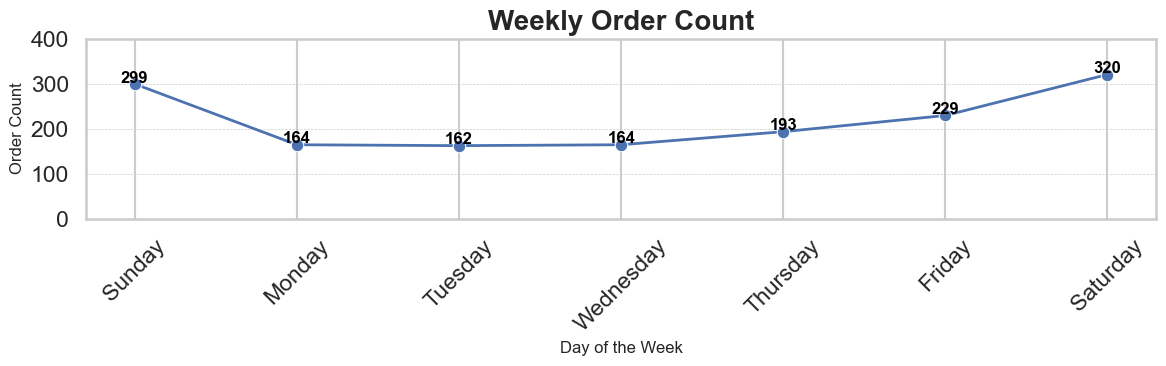

In [8]:
# Weekly Order Count Analysis
query = """
    SELECT 
        strftime('%w', datetime) AS day_of_week,  
        COUNT(DISTINCT order_id) AS order_count
    FROM 
        sales
    GROUP BY 
        day_of_week
    ORDER BY 
        day_of_week
"""

# Execute the SQL query using pandasql
weekly_sales = ps.sqldf(query, locals())

# Map the numerical weekday to the day names
weekly_sales['day_of_week'] = weekly_sales['day_of_week'].astype(int)
weekly_sales['day_of_week'] = weekly_sales['day_of_week'].map({
    0: 'Sunday',
    1: 'Monday', 
    2: 'Tuesday', 
    3: 'Wednesday', 
    4: 'Thursday', 
    5: 'Friday', 
    6: 'Saturday'
})

# Line plot for Weekly Net Sales
plt.figure(figsize=(12, 4))
sns.set(style="whitegrid", context="talk")
# Create lineplot of weekly net sales
s = sns.lineplot(x='day_of_week', y='order_count', data=weekly_sales, marker='o', palette="viridis", linewidth=2)

# Add data labels at each point
for x, y in zip(weekly_sales['day_of_week'], weekly_sales['order_count']):
    plt.text(x, y + 3, f'{int(y)}', ha='center', fontsize=12, color='black', weight='bold')
plt.title('Weekly Order Count', fontsize=20, weight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.ylim(0,400)
plt.xticks(rotation=45)
plt.yticks(range(0, 410, 100))
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')
plt.tight_layout()

>該圖顯示了每週的訂單數量，週二的訂單數量最低（162），而週六的訂單數量最高（320）。訂單數量從週日（299）開始下降至週二，然後在整週內逐漸增加。該圖顯示週末顧客活動較為活躍。

### 平均客單價分析

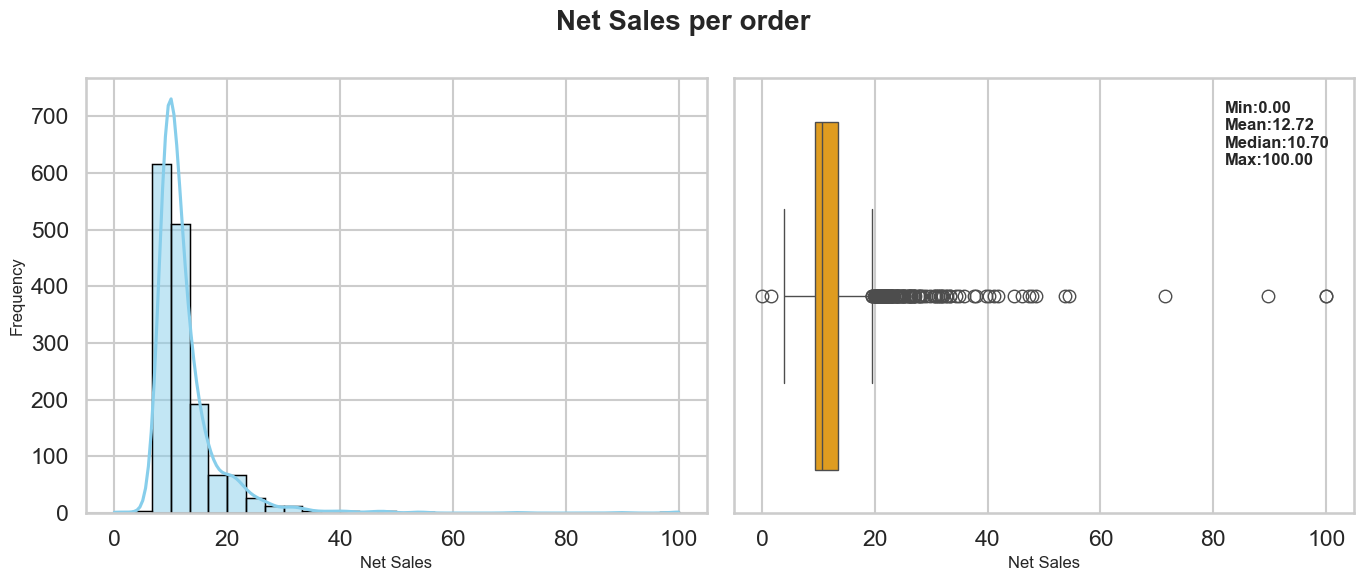

In [9]:
# Net Sales Per Order Analysis
plt.figure(figsize=(14, 6))
plt.suptitle('Net Sales per order', fontsize=20, weight='bold')
# Subplot 1: Histogram with KDE 
plt.subplot(1, 2, 1)
sns.histplot(sales['net_sales'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Net Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Subplot 2: Box Plot with Min, Mean, and Max as Legend
plt.subplot(1, 2, 2)
sns.boxplot(x=sales['net_sales'], color='orange')
plt.xlabel('Net Sales', fontsize=12)

# Calculate Min, Mean, and Max values
min_value = sales['net_sales'].min()
mean_value = sales['net_sales'].mean()
max_value = sales['net_sales'].max()
median_value=sales['net_sales'].quantile()

# Add Min, Mean, and Max values
plt.text(82,-0.3,f'Min:{min_value:.2f}\nMean:{mean_value:.2f}\nMedian:{median_value:.2f}\nMax:{max_value:.2f}',fontsize=12,weight='bold')

plt.tight_layout()

>淨銷售額每筆訂單的分佈高度偏向較低數值。中位數為 10.70，而平均值略高，為 12.72。箱型圖顯示出多個離群值，而大多數訂單的銷售集中在較低區間。

### RFM 分析  
我們可以使用 R（最近購買 Recency）、F（購買頻率 Frequency） 和 M（購買金額 Monetary） 來分析每位顧客的消費行為。

In [10]:
# create a RFM data 
query = """
SELECT
    customer_id,
    JULIANDAY('2024-07-01') - JULIANDAY(MAX(datetime)) AS recency,
    COUNT(DISTINCT order_id) AS frequency,
    SUM(net_sales) AS monetary
FROM
    sales
GROUP BY
    customer_id
ORDER BY
    monetary DESC
"""

# Execute the SQL query
RFM = ps.sqldf(query, locals())

# Drop values that will influence analysis
RFM=RFM[RFM['monetary']<300] # these customers are Purchasing agent, their purchase habits will be different from other customers

RFM[['recency','frequency','monetary']].describe()

,recency,frequency,monetary
count,996.000000,996.000000,996.000000
mean,138.330321,1.466867,18.733675
std,100.516687,1.421976,23.592813
min,0.000000,1.000000,6.520000
25%,50.000000,1.000000,9.470000
50%,114.000000,1.000000,11.675000
75%,225.000000,1.000000,19.340000
max,345.000000,25.000000,295.360000


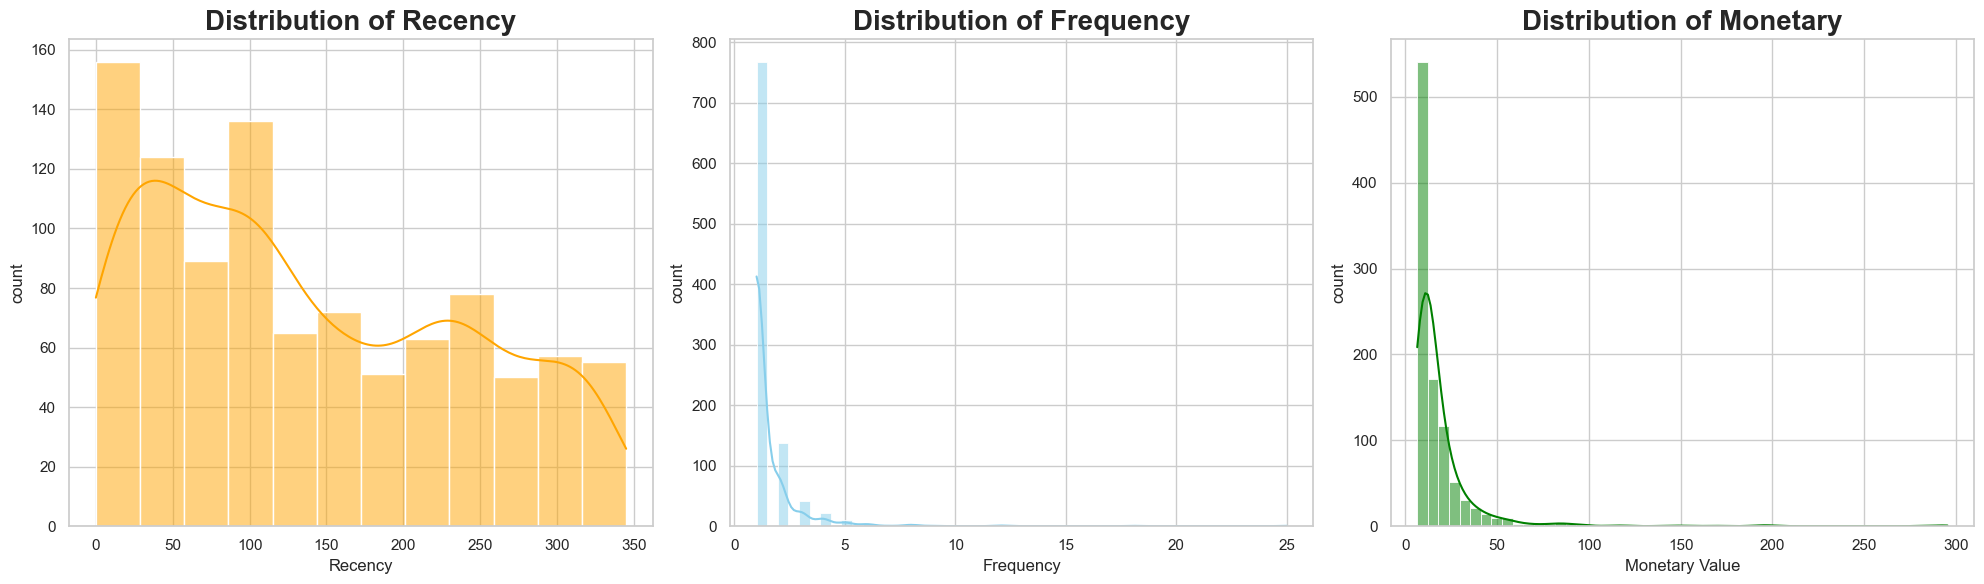

In [11]:
# Plot histplot for RFM data
plt.figure(figsize=(20, 6))  
sns.set(style="whitegrid") 

# Subplot 1 - Recency
plt.subplot(131)
sns.histplot(RFM['recency'], bins=12, color="orange", kde=True)
plt.title('Distribution of Recency', fontsize=20,weight='bold')
plt.xlabel('Recency', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(True)

# Subplot 2 - Frequency
plt.subplot(132)
sns.histplot(RFM['frequency'], bins=50, color="skyblue", kde=True)
plt.title('Distribution of Frequency', fontsize=20,weight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(True)

# Subplot 3 - Monetary
plt.subplot(133)
sns.histplot(RFM['monetary'], bins=50, color="green", kde=True)
plt.title('Distribution of Monetary', fontsize=20,weight='bold')
plt.xlabel('Monetary Value', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(True)

plt.tight_layout()

>從圖表中我們能觀察到：  
最近消費圖表(Recency)：大多數顧客最近都有交易記錄。  
購買頻率圖表(Frequency)：大部分顧客的購買頻率非常低，隨著購買次數增加，顧客數量急劇下降。    
購買金額圖表(Monetary)：大多數顧客的消費金額較低，但少數高價值顧客對總收入貢獻顯著。

### 購買頻率分析

In [12]:
round(RFM[RFM['frequency']==1].shape[0]/RFM['frequency'].shape[0],2)

0.77

<div style="border-left: 5px solid red; padding: 10px; background-color:rgb(237, 212, 212); color:rgb(87, 21, 21);">
    <b>主要問題：</b><br><br>
    我們發現有77%的顧客為一次性消費的顧客，因此我決定設計策略來提升顧客忠誠度：<br> 
    1. VIP 制度<br>
    2. 客製化 email<br>
    3. 免運制度
</div>

# VIP 制度  
### 根據去年總消費金額和單筆訂單消費金額，劃分兩個 VIP 等級，以鎖定高價值顧客並提供專屬優惠。

In [13]:
# Find the 50th percentile and 90th percentile of total sales by each customer
percentile_50 = round(RFM['monetary'].quantile(0.50),2)
percentile_90 = round(RFM['monetary'].quantile(0.90),2)
print(f"50th Percentile of Monetary: {percentile_50}")
print(f"90th Percentile of Monetary: {percentile_90}")

# Find the 90th percentile of sales by each order
percentile_90 = round(sales['net_sales'].quantile(0.90),2)
print(f"90th Percentile of net_sales_per_order: {percentile_90}")

50th Percentile of Monetary: 11.68
90th Percentile of Monetary: 32.02
90th Percentile of net_sales_per_order: 19.13


### VIP: 去年總消費金額達 11.68  
### VVIP: 去年總消費金額達 32.02 或去年有單筆消費金額達 19.13

In [14]:
# tier1 customer: total spending last year exceeded 11.68
# tier2 customer: total spending last year exceeded 32.02 or single transaction amount exceeded 19.13 last year
query=''' 
SELECT 
    s.customer_id,
    CASE 
        WHEN MAX(r.monetary)>=11.68 and MAX(r.monetary)<32.02 THEN "TIER1"
        WHEN MAX(r.monetary)>=32.02 or MAX(s.net_sales)>=19.13 THEN "TIER2"
        ELSE "NULL"
    END as tier
FROM sales s INNER JOIN RFM r on s.customer_id=r.customer_id
GROUP BY s.customer_id
'''
customer_tier=ps.sqldf(query,locals())
customer_tier['tier'].value_counts()

tier
NULL     498
TIER1    398
TIER2    100
Name: count, dtype: int64

<div style="border-left: 5px solid green; padding: 10px; background-color: #d4edda; color: #155724;">
    <b>結果:  </b><br><br>
    1. 我們能看到會有10%顧客成為我們的VVIP、40%顧客成為VIP。<br>
    2. 我們可以針對不同層級的顧客設計刺激機制來提升顧客升級會員等級意願。
</div>

# 客製化 Email  
使用 K-means 分析，根據購買商品偏好和總消費金額將顧客分為三個群組，並針對每個群組制定專屬行銷策略，以提升顧客參與度。

### 計算顧客購買商品偏好及總消費金額  
計算顧客商品偏好（根據顧客過去對不同產品類型的購買記錄，計算加權平均數，偏好分數接近 10 表示更傾向時尚款式，而接近 1 則偏好普通款式）以及每位顧客的總消費金額。

In [15]:
query=''' 
SELECT
    customer_id,
    AVG(CASE 
        WHEN CAST(SUBSTR(product_type, 1, 1) AS INTEGER) = 1 THEN 10
        WHEN CAST(SUBSTR(product_type, 1, 1) AS INTEGER) = 2 THEN 1
        ELSE 0
    END) AS product_preference,
    SUM(net_sales) AS total_sales
FROM
    items
GROUP BY
    customer_id
ORDER BY total_sales DESC
'''
cpp=ps.sqldf(query,locals())

# Drop total_sales>300, these are purchasing agent, their purchase habits will be different from other customers
cpp=cpp[cpp['total_sales']<300]
cpp

,customer_id,product_preference,total_sales
3,1866092896,10.000000,210.77
4,5281799789,6.785714,153.02
5,3182081116,5.153846,127.49
6,3079348898,8.105263,107.99
7,7449397431,10.000000,107.15
...,...,...,...
673,3030191785,1.000000,1.04
674,1936801602,1.000000,1.04
675,600263589,1.000000,1.04
676,154429,1.000000,1.04


### 觀察購買商品偏好及總消費金額是否呈現常態分佈

In [16]:
print("Skewness before transformation:")
print(cpp[['product_preference','total_sales']].skew()) 
# Skewness > 1 or < -1 indicates high skew, then we will have to log these columns

Skewness before transformation:
product_preference    0.479639
total_sales           4.793438
dtype: float64


>總消費金額（total_sales）呈現高度偏態分佈，所以我們會對這個欄位進行對數轉換

### 總消費金額（total_sales）對數轉換

In [17]:
cpp['total_sales_log']=np.log1p(cpp['total_sales'])
print("Skewness after transformation:")
print(cpp[['product_preference','total_sales_log']].skew())

Skewness after transformation:
product_preference    0.479639
total_sales_log       0.645967
dtype: float64


### 使用 Elbow Method 來決定分群數量

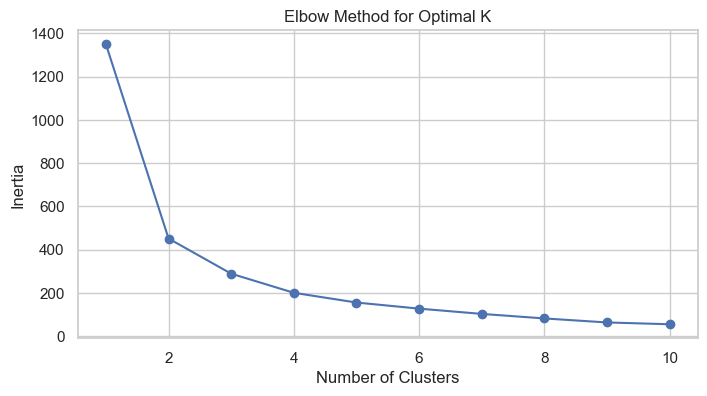

In [18]:
# Normalize product_preference and total_sales_log
scaler = StandardScaler()
cpp_scaled = scaler.fit_transform(cpp[['product_preference','total_sales_log']])

inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(cpp_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

>我們能觀察到3是最好的分群數量

### 使用 K-means 分群

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(cpp_scaled)

# Add the cluster labels to the original DataFrame
cpp['Cluster'] = kmeans.labels_
cpp

,customer_id,product_preference,total_sales,total_sales_log,Cluster
3,1866092896,10.000000,210.77,5.355501,2
4,5281799789,6.785714,153.02,5.037082,2
5,3182081116,5.153846,127.49,4.855851,2
6,3079348898,8.105263,107.99,4.691256,2
7,7449397431,10.000000,107.15,4.683519,2
...,...,...,...,...,...
673,3030191785,1.000000,1.04,0.712950,0
674,1936801602,1.000000,1.04,0.712950,0
675,600263589,1.000000,1.04,0.712950,0
676,154429,1.000000,1.04,0.712950,0


### 分群視覺化

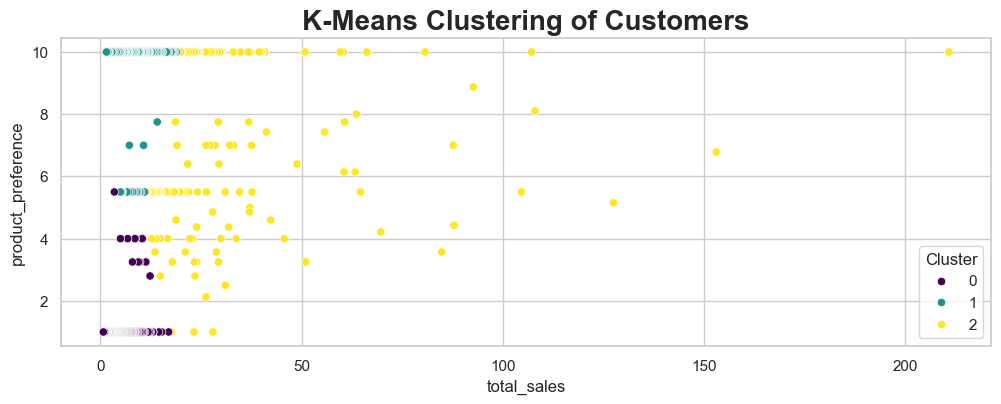

In [20]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x='total_sales', y='product_preference', hue='Cluster', data=cpp, palette='viridis')
plt.title('K-Means Clustering of Customers',fontsize=20,weight='bold')
plt.show()

### 各分群的平均商品購買喜好(product preference) 及總消費金額(total_sales)

In [21]:
cpp[['product_preference','total_sales','Cluster']].groupby('Cluster').mean()

,product_preference,total_sales
Cluster,,
0,1.092244,3.892410
1,9.530702,9.252807
2,6.895668,35.248042


<div style="border-left: 5px solid green; padding: 10px; background-color: #d4edda; color: #155724;">
    <b>結果：</b><br><br>
    1. Cluster 0 顧客總消費金額較低 (平均 3.89) 並且偏好普通款式。 <br>
    2. Cluster 1 顧客總消費金額居中 (平均 9.25) 並且偏好時尚款式。 <br>
    3. Cluster 2 顧客總消費金額最高 (平均 35.25) 並且不同商品款式接受度較高 <br><br>
    -> 我們可以接著針對不同客群設計客製化的email內容來提升顧客參與度
</div>

# 免運制度
通過計算平均客單價、平均產品價格和回購週期，設計免運費政策來提高顧客留存率。

### 計算每筆訂單淨銷售額的第 70 百分位數

In [22]:
percentile_70 = round(sales['net_sales'].quantile(0.70),2)
print(f"70th Percentile of net_sales: {percentile_70}")

70th Percentile of net_sales: 12.7


### 計算免運制度的有效期限 
計算淨銷售額超過 15.7 的訂單的平均回購時間（假設普通款式的平均價格為 3，我們設定訂單金額超過 12.7 + 3 = 15.7 的顧客，下一次回購時可獲得免運資格）。

In [24]:
query=''' 
WITH CTE as(
    SELECT
    customer_id,
    datetime,
    LEAD(datetime)OVER(PARTITION BY customer_id ORDER BY datetime ASC) as next_date,
    net_sales
    FROM sales
),
CTE2 as(
    SELECT
    customer_id,
    JULIANDAY(next_date) - JULIANDAY(datetime) as repurchase_time
    FROM CTE
    WHERE next_date IS NOT NULL and net_sales>15.7
)
SELECT
ROUND(AVG(repurchase_time),0) as mean_repurchase_time
FROM CTE2
'''
mean_repurchase_time=ps.sqldf(query,locals())
mean_repurchase_time

,mean_repurchase_time
0,38.0


>平均回購週期為38天, 我們四捨五入為40天。

<div style="border-left: 5px solid green; padding: 10px; background-color: #d4edda; color: #155724;">
    <b>結果：</b><br><br>
    我們現在可以根據淨銷售額的第 70 百分位數和平均回購時間來制定免運政策。
</div>

# END